In [1]:
import mlflow.sklearn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from graph_reinforcement_learning_using_blockchain_data import config
from graph_reinforcement_learning_using_blockchain_data.modeling import random_forest

config.load_dotenv()

2025-06-22 13:45:02.791 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [2]:
df_features = pd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_without_0logs.csv"
)

In [3]:
df = df_features.drop(columns=["transactionHash", "from", "to", "blockNumber", "transactionIndex"])
df.head()

,gasUsed,cumulativeGasUsed,effectiveGasPrice,status,fee,num_logs,dummy_0x1c411e9a,dummy_0xe1fffcc4,dummy_0xddf252ad,dummy_0xe9149e1b,...,dummy_0x908fb5ee,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0x17307eab,dummy_0x8c5be1e5,dummy_0xddac4093,dummy_0xc42079f9,dummy_0x19b47279,dummy_0x8201aa3f,label
0,157316,2135061,50000000000,1,7865800000000000,6,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,48537,10131517,22000000000,1,1067814000000000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,62833,5225102,19360969611,1,1216507803567963,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,172470,3799719,20100000000,1,3466647000000000,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,254032,2564577,22568554601,1,5733135062401232,11,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [4]:
X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
features_to_scale = ["gasUsed", "cumulativeGasUsed", "effectiveGasPrice", "fee", "num_logs"]

In [6]:
rf_trainer = random_forest.RandomForestTrainer()
grid_search = rf_trainer.grid_search(features_to_scale)

In [7]:
print(rf_trainer)

In [7]:
best_model = rf_trainer.train(X_train, X_test, y_train, y_test, grid_search, "Edge Classification")

2025/05/31 12:46:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  12.3s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  12.4s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  23.6s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  24.3s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  24.4s
[CV] END classifier__max_depth=20, clas

2025/05/31 12:51:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).
"
2025/05/31 12:51:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/ve

🏃 View run casual-crab-847 at: http://127.0.0.1:8080/#/experiments/424550522144417923/runs/fe2ba89010a24a3aa802d5a61e4a4fb7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424550522144417923
🏃 View run useful-bee-576 at: http://127.0.0.1:8080/#/experiments/424550522144417923/runs/9fcd873141f64e60bf351fb7bb47d0a4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424550522144417923
🏃 View run nimble-smelt-421 at: http://127.0.0.1:8080/#/experiments/424550522144417923/runs/d5450f722e3d4de6a0a0fe16492c21b2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424550522144417923
🏃 View run gaudy-fish-439 at: http://127.0.0.1:8080/#/experiments/424550522144417923/runs/e5d1e39cd0c84ffa890bf3003ac493d0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424550522144417923
🏃 View run persistent-seal-39 at: http://127.0.0.1:8080/#/experiments/424550522144417923/runs/b0743baf2a3142fab63a24dc06100a95
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424550522144

2025/05/31 12:51:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


🏃 View run upset-cat-670 at: http://127.0.0.1:8080/#/experiments/424550522144417923/runs/dc223caf60224c66a105dbb2a9ef71e0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424550522144417923


In [8]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE score: {-grid_search.best_score_:.3f}")

Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 30}
Best RMSE score: -0.985


In [9]:
rf = mlflow.sklearn.load_model(
    "mlflow-artifacts:/424550522144417923/dc223caf60224c66a105dbb2a9ef71e0/artifacts/best_estimator"
)

In [11]:
print(rf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['gasUsed',
                                                   'cumulativeGasUsed',
                                                   'effectiveGasPrice', 'fee',
                                                   'num_logs'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=30, min_samples_split=5,
                                        n_estimators=200, random_state=2))])


In [15]:
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Train Accuracy: 0.9939608496459809
Test Accuracy: 0.9845619880605303


In [16]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     14900
           1       0.98      1.00      0.99     21115

    accuracy                           0.98     36015
   macro avg       0.99      0.98      0.98     36015
weighted avg       0.98      0.98      0.98     36015



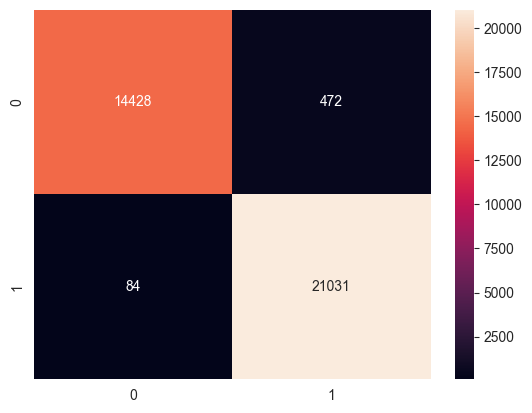

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

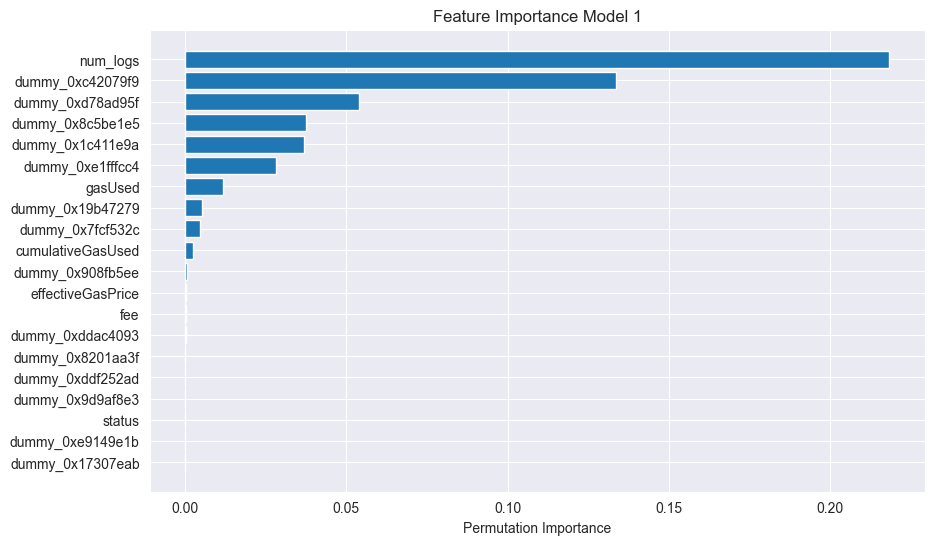

In [18]:
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance Model 1")
plt.show()